In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# MODEL Selection
from sklearn.model_selection import train_test_split, GridSearchCV


# Resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Deep Learning Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

#Metrics
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, roc_auc_score
from yellowbrick.classifier import ConfusionMatrix

# 
# from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

#
from joblib import parallel_backend


2023-01-18 11:31:17.260150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-18 11:31:17.260182: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
def run_model(x_data, y_data, x_test, y_test, model, model_name):
    """
    This function is responsible for taking train data, test data, a model and return the statistics of the
    model.
    :param x_data: features training dataset
    :param y_data: class training dataset
    :param x_test: features test dataset
    :param y_test: class test dataset
    :param model: machine learning model
    :param model_name: model name
    :return: list with model name, accuracy_score, precision_score, recall_score, f1_score
    """
    print(model_name)
    model.fit(x_data,y_data)
    prediction = model.predict(x_test)
    acc_score = accuracy_score(y_test, prediction)
    preci_score = precision_score(y_test, prediction, average='binary')
    recall_score_ = recall_score(y_test, prediction, average='binary')
    f1_score_ = f1_score(y_test, prediction)

    cm = ConfusionMatrix(model)
    plt.figure(figsize=(4,4))
    cm.score(x_test,y_test)
    cm.show()
    plt.show()
    
    return [model_name, acc_score, preci_score, recall_score_, f1_score_]

<p>We are going to load the cleaned data to proceed with the analysis</p>

In [5]:
data = pd.read_csv('train_df_cleaned.csv')
print('train_data: ',data.shape)
test_data = pd.read_csv('test_df_cleaned.csv')
print('test_data: ',test_data.shape)

train_data:  (69999, 125)
test_data:  (30000, 124)


<p> The first thing to do is to seperate the features from the label column for the train data</p>

In [6]:
# separating features from labels
x = data.drop('churn_probability', axis=1)
print(x.shape)
y = data['churn_probability']
print(y.shape)

(69999, 124)
(69999,)


<p>Next step we are going to scale the data in order to have all the values in the same scale.</p>
<p>We fit the scale to the train data and transform the same data and then scale the test data.</p>

In [7]:
# Scaling data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
test_data_scaled = scaler.transform(test_data)

<h4>Time to start defining models and run some tests</h4>
<p> If we analyse the class distribution, we'll see that we have a very imbalanced dataset</p>

In [8]:
# checking the balance of the data
neg, pos= np.bincount(y)
print('Negative class:', neg)
print('Positive class:', pos)
total = pos + neg

Negative class: 62867
Positive class: 7132


<p>We are going to run the following scenarios first:</p>
<ol>
    <li>Use the imbalanced data</li>
    <li>Use the balanced data, with SMOTE</li>
    <li>Use the balanced data, with SMOTE and Random UnderSampling</li>
</ol>

<p>For each of these scenarios we are going to use the <strong>DecisionTreeClassifier</strong> and <strong>RandomForrestClassifier</strong>, because they perform well for imbalanced data.</p>
<p>After finding out which classifier performs better for each of these scenarios we will perform a search for the best hyperparameters.</p>

<p>For that we start by spliting the dataset into, train and test data</p>

In [9]:
# split between train data and test data
x_train, x_test, y_train, y_test = train_test_split(x_scaled,y, test_size=0.2, random_state=100)

Decision Tree


/home/salvado/.local/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


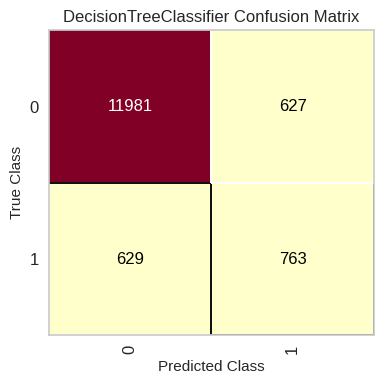

Random Forest


/home/salvado/.local/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


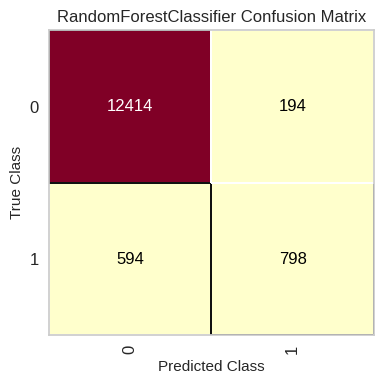

,Accuracy,Precison 1,Recall 1,F1 Score
Decision Tree,0.910286,0.548921,0.548132,0.548526
Ramdom Forrest,0.943714,0.804435,0.573276,0.669463


In [10]:
# Imbalanced Data models


# compute class_weights
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

# models with standard hyperparameters - for a first analysis
models = {'Decision Tree': DecisionTreeClassifier(class_weight=class_weight),
         'Random Forest': RandomForestClassifier(class_weight=class_weight)}

results_imbalanced = []
with parallel_backend('threading', n_jobs=-1):
    for model_name, model in zip(models.keys(), models.values()):
        result= run_model(x_train, y_train, x_test, y_test, model, model_name)
        results_imbalanced.append(result)
        
# [model_name, acc_score, preci_score, recall_score, f1_score]
    
Imbalanced = pd.DataFrame.from_dict({
    'Decision Tree':[results_imbalanced[0][1], 
                    results_imbalanced[0][2], results_imbalanced[0][3],
                    results_imbalanced[0][4]],
    'Ramdom Forrest':[results_imbalanced[1][1], 
                    results_imbalanced[1][2],results_imbalanced[1][3],
                    results_imbalanced[1][4]],
                    
}, columns=['Accuracy', 'Precison 1', 'Recall 1', 'F1 Score'], orient='index')
                    
Imbalanced 


Decision Tree


/home/salvado/.local/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


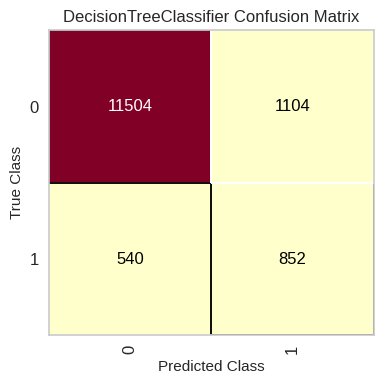

Random Forest


/home/salvado/.local/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


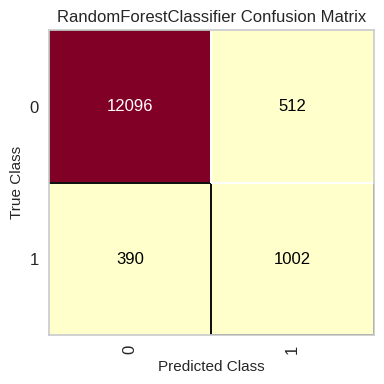

,Accuracy,Precison 1,Recall 1,F1 Score
Decision Tree,0.882571,0.435583,0.612069,0.508961
Ramdom Forrest,0.935571,0.661823,0.719828,0.689608


In [11]:
# Reampled Data - OverSampling


# models with standard hyperparameters - for a first analysis
models = {'Decision Tree': DecisionTreeClassifier(),
         'Random Forest': RandomForestClassifier()}


# SMOTE 
over = SMOTE()
x_train_over, y_train_over = over.fit_resample(x_train, y_train)
results_over = []
with parallel_backend('threading', n_jobs=-1):
    
    for model_name, model in zip(models.keys(), models.values()):
        result= run_model(x_train_over, y_train_over, x_test, y_test, model, model_name)
        results_over.append(result)
        
Over = pd.DataFrame.from_dict({
    'Decision Tree':[results_over[0][1], 
                    results_over[0][2], results_over[0][3],
                    results_over[0][4]],
    'Ramdom Forrest':[results_over[1][1], 
                    results_over[1][2],results_over[1][3],
                    results_over[1][4]],
                    
}, columns=['Accuracy', 'Precison 1', 'Recall 1', 'F1 Score'], orient='index')

Over

/home/salvado/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Negative class: 25129
Positive class: 25129
Decision Tree


/home/salvado/.local/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


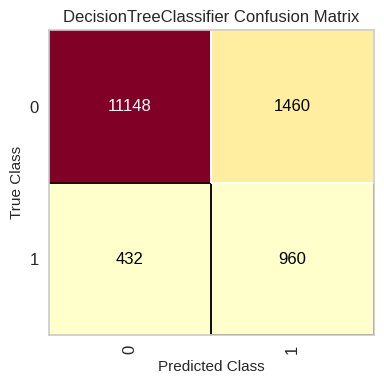

Random Forest


/home/salvado/.local/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


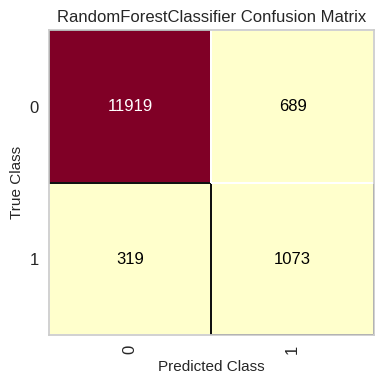

,Accuracy,Precison 1,Recall 1,F1 Score
Decision Tree,0.864857,0.396694,0.689655,0.503673
Ramdom Forrest,0.928000,0.608967,0.770833,0.680406


In [12]:
# Resampled Data . OverSampling and RandomUnderSampling
over = SMOTE(sampling_strategy=0.5,n_jobs=-1,)
under = RandomUnderSampler(sampling_strategy=1,)

x_train_over_under, y_train_over_under = over.fit_resample(x_train, y_train)
x_train_over_under, y_train_over_under = under.fit_resample(x_train_over_under, y_train_over_under)


# checking the balance of the data
neg, pos= np.bincount(y_train_over_under)
print('Negative class:', neg)
print('Positive class:', pos)
total = pos + neg


# models with standard hyperparameters - for a first analysis
models = {'Decision Tree': DecisionTreeClassifier(), 
         'Random Forest': RandomForestClassifier()}


results_over_under = []
with parallel_backend('threading', n_jobs=-1):
    for model_name, model in zip(models.keys(), models.values()):
        result = run_model(x_train_over_under, y_train_over_under, x_test, y_test, model, model_name)
        results_over_under.append(result)

Over_under = pd.DataFrame.from_dict({
    'Decision Tree':[results_over_under[0][1], 
                    results_over_under[0][2], results_over_under[0][3],
                    results_over_under[0][4]],
    'Ramdom Forrest':[results_over_under[1][1], 
                    results_over_under[1][2],results_over_under[1][3],
                    results_over_under[1][4]],
                    
}, columns=['Accuracy', 'Precison 1', 'Recall 1', 'F1 Score'], orient='index')

Over_under



In [13]:
results_all = pd.concat({'Imbalanced': Imbalanced, 'Over': Over,'Over-Under': Over_under}, axis=1)
results_all

Imbalanced                                     Over             \
                 Accuracy Precison 1  Recall 1  F1 Score  Accuracy Precison 1   
Decision Tree    0.910286   0.548921  0.548132  0.548526  0.882571   0.435583   
Ramdom Forrest   0.943714   0.804435  0.573276  0.669463  0.935571   0.661823   

                                   Over-Under                                 
                Recall 1  F1 Score   Accuracy Precison 1  Recall 1  F1 Score  
Decision Tree   0.612069  0.508961   0.864857   0.396694  0.689655  0.503673  
Ramdom Forrest  0.719828  0.689608   0.928000   0.608967  0.770833  0.680406

<Figure size 600x600 with 0 Axes>

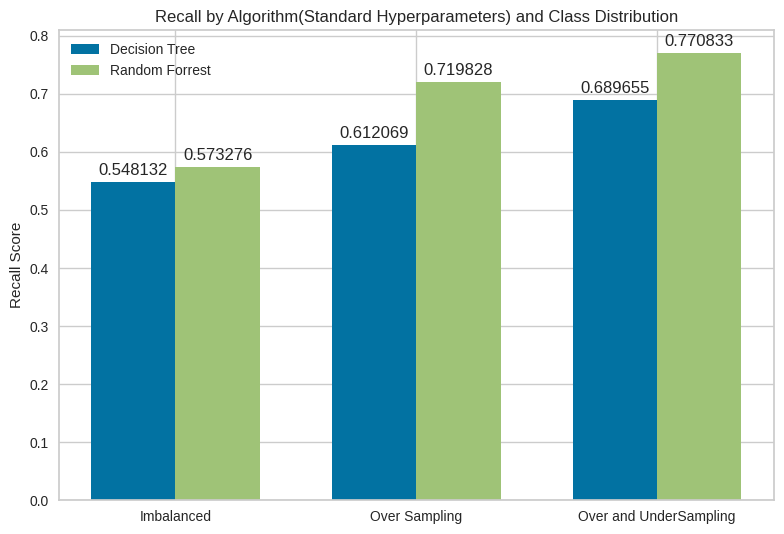

In [14]:
# plot recall 
labels = ['Imbalanced', 'Over Sampling', 'Over and UnderSampling']  #['G1', 'G2', 'G3', 'G4', 'G5']
tree = [results_all['Imbalanced']['Recall 1'][0],
        results_all['Over']['Recall 1'][0],
        results_all['Over-Under']['Recall 1'][0]]

r_forrest = [results_all['Imbalanced']['Recall 1'][1],
        results_all['Over']['Recall 1'][1],
        results_all['Over-Under']['Recall 1'][1]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, tree, width, label='Decision Tree')
rects2 = ax.bar(x + width/2, r_forrest, width, label='Random Forrest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Recall Score')
ax.set_title('Recall by Algorithm(Standard Hyperparameters) and Class Distribution')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.show()

<p>We can observe that the best results, as stated in the bibliography, is a mix of SMOTE and RandomUnderSampling</p>
<p>We will now proceed with further analysis to see if we can improve the results by seaching for the best combination of hyperparameters with GridSearchCV</p>

In [15]:
# RandomForrestClassifier GridSearchCV

# RandomForestClassifier(n_estimators =100, min_samples_leaf=1, min_samples_leaf=1, class_weight='balanced', criterion='gini', )
parameters = {'criterion': ['gini', 'log_loss','entropy'],
             'n_estimators': [50, 100, 150],
             'min_samples_leaf': [1,2],'min_samples_split': [2,4]}
with parallel_backend('threading', n_jobs=-1):
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid=parameters, verbose=0,n_jobs=-1, scoring='recall')
    grid_search.fit(x_train_over_under,y_train_over_under)

    print(grid_search.score(x_test, y_test))
    prediction = grid_search.predict(x_test)

    print(grid_search.best_params_)


#Recall: 0.7722701149425287
# {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}

0.7751436781609196
{'criterion': 'log_loss', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [23]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     12608
           1       0.58      0.77      0.67      1392

    accuracy                           0.92     14000
   macro avg       0.78      0.86      0.81     14000
weighted avg       0.94      0.92      0.93     14000



<p>After finding the best parameters from the options given. We'll train and test the model and check how it behaves</p>

Random Forrest


/home/salvado/.local/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


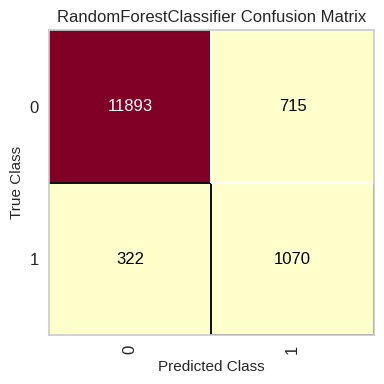

Recall 0.7686781609195402


In [16]:
rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=1, min_samples_split=2, n_estimators=150)
random_forrest = run_model(x_train_over_under, y_train_over_under, x_test, y_test, rf, 'Random Forrest')

print('Recall', random_forrest[3])

<p>So far we have been able to improve the classification of class 1 which is the class more important to predict for our stakeholder</p>
<p>We will try to improve the results by changing the SMOTE hyperparameter, k_neighbors, to check if the "clustering" strategy can have any impact on the results</p>
<p>The standard k_neighbors is 5, we will check if for a list from 2 neighbors to 9 the results can be improved.</p>

In [21]:


# Resampled Data . Over and Under
k_values = np.arange(2,10)
k_values_recall = []
for k in k_values:
    print('Neightboors: ', k)
    over = SMOTE(sampling_strategy=0.5, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=1)

    x_train_over_under, y_train_over_under = over.fit_resample(x_train, y_train)
    x_train_over_under, y_train_over_under = under.fit_resample(x_train_over_under, y_train_over_under)


    rf = RandomForestClassifier(criterion='log_loss',
                                min_samples_leaf=1,
                                min_samples_split=2,
                                n_estimators=150,
                                n_jobs=-1)
    rf.fit(x_train_over_under, y_train_over_under)
    prediction = rf.predict(x_test)
    recall_ = recall_score(y_test, prediction)
    
    k_values_recall.append([k, recall_])
    


Neightboors:  2
Neightboors:  3
Neightboors:  4
Neightboors:  5
Neightboors:  6
Neightboors:  7
Neightboors:  8
Neightboors:  9


In [22]:
# identifying the best recall score according to k neighbors values
max_ = 0
k_value = 0
for k, recall_ in k_values_recall:
    if recall_ > max_:
        max_ = recall_
        k_value = k
print(f'the best combination is for {k_value} with a Recall socre {max_}.')

the best combination is for 8 with a Recall socre 0.7794540229885057.


Random Forrest


/home/salvado/.local/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


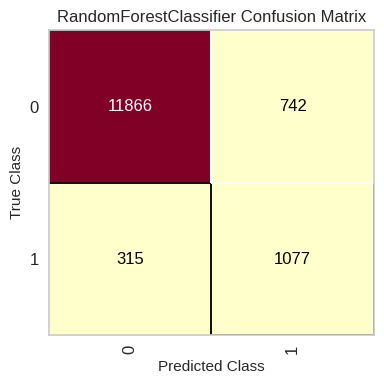

Recall 0.7737068965517241


In [23]:
# final model for SMOTE and RandomUnderSampling

over = SMOTE(sampling_strategy=0.5, k_neighbors=k_value)
under = RandomUnderSampler(sampling_strategy=1)

x_train_over_under, y_train_over_under = over.fit_resample(x_train, y_train)
x_train_over_under, y_train_over_under = under.fit_resample(x_train_over_under, y_train_over_under)


rf = RandomForestClassifier(criterion='log_loss',
                            min_samples_leaf=1,
                            min_samples_split=2,
                            n_estimators=150,
                            n_jobs=-1)
random_forrest_final = run_model(x_train_over_under, y_train_over_under, x_test, y_test, rf, 'Random Forrest')

print('Recall', random_forrest_final[3])

In [16]:
# Verify the scores for all the data - Apllying the RepeatedStratifiedKFold

# final model for imbalanced data.

over = SMOTE(sampling_strategy=0.5, k_neighbors=k_value, n_jobs=-1)
under = RandomUnderSampler(sampling_strategy=1)

x_train_over_under, y_train_over_under = over.fit_resample(x_scaled, y)
x_train_over_under, y_train_over_under = under.fit_resample(x_train_over_under, y_train_over_under)

rf = RandomForestClassifier(criterion='log_loss',
                            min_samples_leaf=1,
                            min_samples_split=2,
                            n_estimators=150,
                            n_jobs=-1)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,)
recall_scores = cross_val_score(rf, x_train_over_under, y_train_over_under, scoring='recall', cv=cv, n_jobs=-1)

/home/salvado/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [17]:
recall_scores.mean()

0.9354396201205905

In [24]:

# training the model with all the data

over = SMOTE(sampling_strategy=0.5, k_neighbors=k_value)
under = RandomUnderSampler(sampling_strategy=1)

x_train_over_under, y_train_over_under = over.fit_resample(x_scaled, y)
x_train_over_under, y_train_over_under = under.fit_resample(x_train_over_under, y_train_over_under)

RandomForestClassifier()

rf_final = RandomForestClassifier(criterion='log_loss',
                                  min_samples_leaf=1,
                                  min_samples_split=2,
                                  n_estimators=150,
                                  n_jobs=-1)
rf_final.fit(x_train_over_under, y_train_over_under)


RandomForestClassifier(criterion='log_loss', n_estimators=150, n_jobs=-1)

In [26]:
prediction = rf_final.predict(test_data_scaled)

In [27]:
sample_submission = pd.read_csv('sample.csv')
sample_submission.shape

(30000, 2)

In [28]:
sample_submission['churn_probability'] = prediction

In [29]:
sample_submission.to_csv('sample_submission.csv', header=True, columns=['id', 'churn_probability'], index=False, index_label='id')

In [ ]:
# 10th place

In [ ]:
# Deep Learning Network

In [33]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [34]:
model = Sequential()
model.add(keras.layers.Input(shape=(124,)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                8000      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,065
Trainable params: 8,065
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=METRICS)

In [38]:
over = SMOTE(sampling_strategy=0.5, k_neighbors=8)
under = RandomUnderSampler(sampling_strategy=1)

x_train_over_under, y_train_over_under = over.fit_resample(x_scaled, y)
x_train_over_under, y_train_over_under = under.fit_resample(x_train_over_under, y_train_over_under)


In [39]:
x_train_ou_train, x_train_ou_val, y_train_ou_train, y_train_ou_val = train_test_split(x_train_over_under,
                                                                                      y_train_over_under,
                                                                                     test_size=0.2,
                                                                                     random_state=100)

In [40]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_recall', min_delta=1e-4, patience=10)
                                        

In [41]:
history = model.fit(x_train_ou_train, y_train_ou_train, epochs=50, validation_data=(x_train_ou_val, y_train_ou_val),
         callbacks=earlystop)

Epoch 1/50
1572/1572 [==============================] - 8s 4ms/step - loss: 0.4214 - tp: 21204.0000 - fp: 5205.0000 - tn: 20055.0000 - fn: 3828.0000 - accuracy: 0.8204 - precision: 0.8029 - recall: 0.8471 - auc: 0.8952 - prc: 0.8858 - val_loss: 0.3419 - val_tp: 5465.0000 - val_fp: 810.0000 - val_tn: 5363.0000 - val_fn: 936.0000 - val_accuracy: 0.8611 - val_precision: 0.8709 - val_recall: 0.8538 - val_auc: 0.9300 - val_prc: 0.9299
Epoch 2/50
1572/1572 [==============================] - 5s 3ms/step - loss: 0.3535 - tp: 21385.0000 - fp: 3509.0000 - tn: 21751.0000 - fn: 3647.0000 - accuracy: 0.8577 - precision: 0.8590 - recall: 0.8543 - auc: 0.9252 - prc: 0.9217 - val_loss: 0.3231 - val_tp: 5549.0000 - val_fp: 748.0000 - val_tn: 5425.0000 - val_fn: 852.0000 - val_accuracy: 0.8728 - val_precision: 0.8812 - val_recall: 0.8669 - val_auc: 0.9369 - val_prc: 0.9370
Epoch 3/50
1572/1572 [==============================] - 5s 3ms/step - loss: 0.3361 - tp: 21524.0000 - fp: 3312.0000 - tn: 21948.0000

In [42]:
prediction = model.predict(test_data_scaled)
prediction = [1 if x > 0.5 else 0 for x in prediction]


938/938 [==============================] - 1s 1ms/step


In [37]:
# Submit for competition
sample_submission = pd.read_csv('sample.csv')
sample_submission.shape
sample_submission['churn_probability'] = prediction
sample_submission.to_csv('sample_submission.csv', header=True, columns=['id', 'churn_probability'], index=False, index_label='id')

In [43]:
recall_dp = history.history['val_recall'][np.argmax(history.history['val_recall'])]
recall_dp

0.8959537744522095

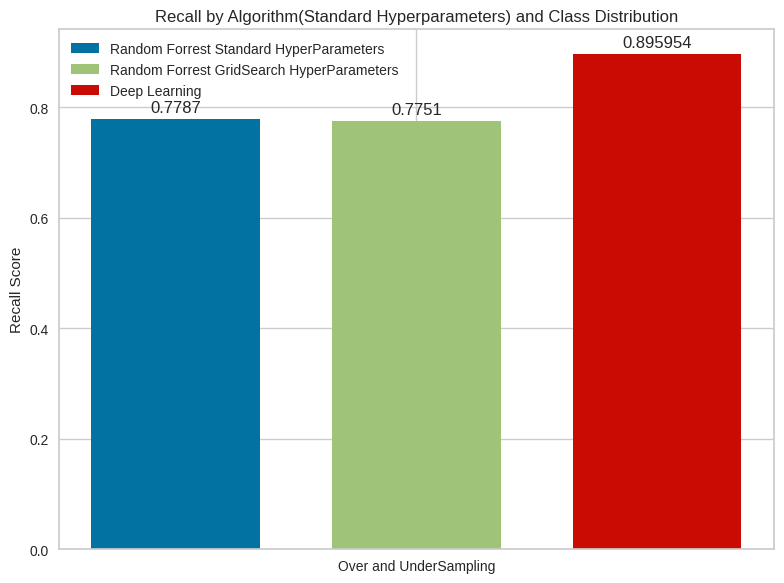

In [44]:
# plot recall 
labels = ['Over and UnderSampling']
r_forrest = [0.7787]

r_forrest_grid_search = [0.7751]

deep_learning = [recall_dp]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - 0.5, r_forrest, width, label='Random Forrest Standard HyperParameters')
rects2 = ax.bar(x , r_forrest_grid_search, width, label='Random Forrest GridSearch HyperParameters')
rects3 = ax.bar(x + 0.5, deep_learning, width, label='Deep Learning')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Recall Score')
ax.set_title('Recall by Algorithm(Standard Hyperparameters) and Class Distribution')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
fig.tight_layout()
plt.show()